In [196]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [197]:
df_original = pd.read_csv("/Users/gabrielrodrigues/Desktop/Python_projects/DB_csv/Sport car price.csv")
df = df_original.copy()

In [198]:
#Definindo função para categorizar outliers:
class Outliers:
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature
    
    def outliers_inferiores(self):
        IQR = self.df[self.feature].quantile(0.75) - self.df[self.feature].quantile(0.25)
        outliers_inferiores = self.df[self.feature].quantile(0.25) - (1.5 * IQR)
        posicao_outliers_inferiores = self.df.loc[self.df[self.feature] <= outliers_inferiores].index
        return posicao_outliers_inferiores

    def outliers_superiores(self):
        IQR = self.df[self.feature].quantile(0.75) - self.df[self.feature].quantile(0.25)
        outliers_superiores = self.df[self.feature].quantile(0.75) + (1.5 * IQR)
        posicao_outliers_superiores = self.df.loc[self.df[self.feature] >= outliers_superiores].index
        return posicao_outliers_superiores

In [199]:
df.head()

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,Porsche,911,2022,3,379,331,4,"101,200"
1,Lamborghini,Huracan,2021,5.2,630,443,2.8,"274,390"
2,Ferrari,488 GTB,2022,3.9,661,561,3,"333,750"
3,Audi,R8,2022,5.2,562,406,3.2,"142,700"
4,McLaren,720S,2021,4,710,568,2.7,"298,000"


In [200]:
#Podemos observar que há colunas com valores nulos, será necessário avaliar qual estratégia sera utilizada para imputação desses valores
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Car Make                 1007 non-null   object
 1   Car Model                1007 non-null   object
 2   Year                     1007 non-null   int64 
 3   Engine Size (L)          997 non-null    object
 4   Horsepower               1007 non-null   object
 5   Torque (lb-ft)           1004 non-null   object
 6   0-60 MPH Time (seconds)  1007 non-null   object
 7   Price (in USD)           1007 non-null   object
dtypes: int64(1), object(7)
memory usage: 63.1+ KB


In [201]:
#Verificando os indices que apresentam Engine Size (L) Nulo
lista_indices_nan = df.loc[df["Engine Size (L)"].isnull()].index
df.loc[df["Engine Size (L)"].isnull()]

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
168,Rimac,C_Two,2022,NaN,1914,1696,1.9,"2,400,000"
171,Tesla,Model S Plaid,2021,NaN,1020,1050,1.98,"131,190"
222,Porsche,Taycan Turbo S,2021,NaN,750,774,2.6,"185,000"
247,Tesla,Model S Plaid,2022,NaN,1020,1050,1.9,"131,190"
387,Rimac,C_Two,2022,NaN,1888,1696,1.8,"2,400,000"
389,Tesla,Roadster,2022,NaN,10000+,0,1.9,"200,000"
686,Rimac,C_Two,2022,NaN,1914,1696,1.85,"2,400,000"
697,Lotus,Evija,2022,NaN,1972,1254,2.5,"2,700,000"
752,Porsche,Taycan,2022,NaN,469,479,3.8,"79,900"
916,Tesla,Roadster,2022,NaN,"10,000+",NaN,1.9,"200,000"


In [202]:
#Criaremos a seguinte função:
#substituição dos valores nulos, pelo valor de moda da coluna Engine Size (L) que possui o mesmo Car Make e o mesmo Car Model
for i in lista_indices_nan:
    Engine_Size_moda = df.loc[(df["Car Make"] == df["Car Make"][i]) &
    (df["Car Model"] == df["Car Model"][i])]["Engine Size (L)"].mode().values[0]
    
    df.loc[i,"Engine Size (L)"] = Engine_Size_moda

In [203]:
df.loc[lista_indices_nan]

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
168,Rimac,C_Two,2022,Electric,1914,1696,1.9,"2,400,000"
171,Tesla,Model S Plaid,2021,Electric,1020,1050,1.98,"131,190"
222,Porsche,Taycan Turbo S,2021,Electric,750,774,2.6,"185,000"
247,Tesla,Model S Plaid,2022,Electric,1020,1050,1.9,"131,190"
387,Rimac,C_Two,2022,Electric,1888,1696,1.8,"2,400,000"
389,Tesla,Roadster,2022,Electric,10000+,0,1.9,"200,000"
686,Rimac,C_Two,2022,Electric,1914,1696,1.85,"2,400,000"
697,Lotus,Evija,2022,Electric,1972,1254,2.5,"2,700,000"
752,Porsche,Taycan,2022,Electric,469,479,3.8,"79,900"
916,Tesla,Roadster,2022,Electric,"10,000+",NaN,1.9,"200,000"


In [204]:
#Percebe-se que carros que possuem pelo menos um motor eletrico podem ser diferenciados através do tamanho de sua string
df["Engine Size (L)"].value_counts()

Engine Size (L)
4                       219
6.2                     113
3                        85
3.5                      79
5                        68
6.5                      46
Electric                 46
3.8                      38
3.7                      35
2                        34
3.9                      30
2.9                      30
5.2                      29
6                        28
2.5                      25
4.7                      23
8                        23
4.4                      11
6.8                       6
1.7                       4
1.8                       3
6.6                       3
8.4                       3
Electric Motor            3
Hybrid                    2
1.5                       2
4.6                       1
6.3                       1
6.4                       1
0                         1
4.0 (Hybrid)              1
2.0 (Electric)            1
5.7                       1
3.6                       1
Hybrid (4.0)              1
7   

In [205]:
#Acho interessante também criamos uma feature de para atribuir se um carro possui motor elétrico
#Isso irá nos ajudar futuramente
df.insert(4,"Electric", value="No", allow_duplicates = True)
df

,Car Make,Car Model,Year,Engine Size (L),Electric,Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,Porsche,911,2022,3,No,379,331,4,"101,200"
1,Lamborghini,Huracan,2021,5.2,No,630,443,2.8,"274,390"
2,Ferrari,488 GTB,2022,3.9,No,661,561,3,"333,750"
3,Audi,R8,2022,5.2,No,562,406,3.2,"142,700"
4,McLaren,720S,2021,4,No,710,568,2.7,"298,000"
...,...,...,...,...,...,...,...,...,...
1002,Koenigsegg,Jesko,2022,5,No,1280,1106,2.5,"3,000,000"
1003,Lotus,Evija,2021,Electric Motor,No,1972,1254,2,"2,000,000"
1004,McLaren,Senna,2021,4,No,789,590,2.7,"1,000,000"
1005,Pagani,Huayra,2021,6,No,764,738,3,"2,600,000"


In [206]:
#Alterando os valores da nova coluna "Electric" para os carros que possuem o motor eletrico
indices_eletricos = df.loc[(df["Engine Size (L)"].str.len() > 3) | (df["Engine Size (L)"]== "0") | (df["Engine Size (L)"] == "-")].index
df.loc[indices_eletricos,"Electric"] = "Yes"

In [207]:
#Confirmando se os indices atribuidos estão de acordo com a clasificação
df.loc[indices_eletricos]["Engine Size (L)"].value_counts()

Engine Size (L)
Electric                46
Electric Motor           3
Hybrid                   2
1.5 + Electric           1
-                        1
Electric (tri-motor)     1
Electric (93 kWh)        1
Electric (100 kWh)       1
Hybrid (4.0)             1
2.0 (Electric)           1
4.0 (Hybrid)             1
0                        1
Name: count, dtype: int64

In [208]:
#Transformando os valores da coluna Engine Size (L) em floats
#Atribuindo 0.0 para carros 100% elétricos
for i in df["Engine Size (L)"].index:
    valor = df.loc[i,"Engine Size (L)"]
    #Caso possível a conversão direta para float, significa que há apenas digitos na string
    try:
        df.loc[i,"Engine Size (L)"] = float(valor)
    #Caso contrario, verificar se há algum digito, pois, pode ser um carro hibrido e conter informações de ambos os motores  
    except ValueError:
        novo_valor = ""
        for letra in valor:
            #Percorrendo caracter por caracter dentro da string e mantendo apenas os digitos e o ".", pois é um float
            if letra.isdigit() or letra == ".":
                novo_valor+=letra
            else:
                df.loc[i,"Engine Size (L)"] = 0.0     
        #Caso a string não esteja vazia, ou o valor seja menor que 20, definir como float        
        if (len(novo_valor) > 0) and (float(novo_valor) < 20):
            df.loc[i,"Engine Size (L)"] = float(novo_valor)
        #Caso a o valor seja maior que vinte, se trata de um elétrico contendo as informações de Kwh    
        else:
            df.loc[i,"Engine Size (L)"] = 0.0
#Por fim, designando a coluna como type float            
df["Engine Size (L)"] = df["Engine Size (L)"].astype("float64")            

In [209]:
#Validando as variaveis
df["Engine Size (L)"].value_counts()

Engine Size (L)
4.0    221
6.2    113
3.0     85
3.5     79
5.0     68
0.0     56
6.5     46
3.8     38
3.7     35
2.0     35
3.9     30
2.9     30
5.2     29
6.0     28
2.5     25
4.7     23
8.0     23
4.4     11
6.8      6
1.7      4
1.5      3
8.4      3
6.6      3
1.8      3
3.6      1
6.3      1
6.4      1
5.7      1
3.3      1
4.6      1
5.5      1
6.7      1
7.0      1
2.3      1
Name: count, dtype: int64

In [210]:
#Iremos utilizar o mesmo método utilizado na coluna Engine Size (L) para tratar da coluna Torque (lb-ft):

#Lista dos indices que apresentam NaN na coluna Torque (lb-ft)
indices_nulos_Torque = df.loc[df["Torque (lb-ft)"].isnull()].index

#Visualizando os valores:
df.loc[df["Torque (lb-ft)"].isnull()]

,Car Make,Car Model,Year,Engine Size (L),Electric,Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
642,Tesla,Model S Plaid,2021,0.0,Yes,1020,NaN,1.9,"139,990"
878,Maserati,GranTurismo,2021,0.0,Yes,550,NaN,2.8,"200,000"
916,Tesla,Roadster,2022,0.0,Yes,"10,000+",NaN,1.9,"200,000"


In [211]:
for i in indices_nulos_Torque:
    #Adequação do valor nulo, para o valor de moda do Torque para a mesma marca e modelo do carro
    Torque_moda = df.loc[(df["Car Make"] == df["Car Make"][i]) & (df["Car Model"] == df["Car Model"][i])]["Torque (lb-ft)"].mode()[0]
    df.loc[i,"Torque (lb-ft)"] = Torque_moda

In [212]:
#Valores alterados
df.loc[indices_nulos_Torque]

,Car Make,Car Model,Year,Engine Size (L),Electric,Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
642,Tesla,Model S Plaid,2021,0.0,Yes,1020,1050,1.9,"139,990"
878,Maserati,GranTurismo,2021,0.0,Yes,550,384,2.8,"200,000"
916,Tesla,Roadster,2022,0.0,Yes,"10,000+",737,1.9,"200,000"


In [213]:
df.loc[[335,354,885,898,965]]

,Car Make,Car Model,Year,Engine Size (L),Electric,Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
335,Tesla,Roadster,2022,0.0,Yes,1000+,-,1.9,"200,000"
354,Tesla,Roadster,2022,0.0,Yes,1000+,"10,000+",1.9,"200,000"
885,Tesla,Roadster,2022,0.0,Yes,"10,000","7,376",1.9,"200,000"
898,Bugatti,Chiron,2021,8.0,No,"1,500","1,180",2.4,"3,000,000"
965,Tesla,Model S Plaid,2022,0.0,Yes,"1,020","1,050",1.9,"141,190"


In [214]:
#Agora acredito que seria interessante padronizarmos os valores da coluna Torque, visto que há alguns valores com "," e "+"
nao_int = []
for i in df["Torque (lb-ft)"].index:
    valor = df.loc[i,"Torque (lb-ft)"]
    #Caso o valor possa ser tranformado em inteiro
    try:
        df.loc[i,"Torque (lb-ft)"] = int(valor)
    #Caso contrário, significa que á letras ou caracteres especiais dentro da string    
    except ValueError:
        nao_int.append(i)
        novo_valor = ""
        #Agora percorreremos cada letra dentro da string, iremos prencher a variavel apenas com os digitos
        for letra in valor:
            if letra.isdigit():
                novo_valor += letra

        df.loc[i,"Torque (lb-ft)"] = novo_valor
        
    car_make = df.loc[i,"Car Make"]
    car_model = df.loc[i,"Car Model"]
    moda_torque = df.loc[(df["Car Make"] == car_make) & (df["Car Model"] == car_model)]["Torque (lb-ft)"].mode()[0]
    df.loc[i,"Torque (lb-ft)"] = moda_torque

df["Torque (lb-ft)"] = df["Torque (lb-ft)"].astype("int64")   

/var/folders/yj/1pvxstrn6g5dsr757vgfj8km0000gn/T/ipykernel_87704/3172061095.py:21: UserWarning:

Unable to sort modes: '<' not supported between instances of 'str' and 'int'



In [215]:
#Problema de caracteres especiais solucionado
df.loc[nao_int]

,Car Make,Car Model,Year,Engine Size (L),Electric,Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
335,Tesla,Roadster,2022,0.0,Yes,1000+,737,1.9,"200,000"
354,Tesla,Roadster,2022,0.0,Yes,1000+,737,1.9,"200,000"
885,Tesla,Roadster,2022,0.0,Yes,"10,000",737,1.9,"200,000"
898,Bugatti,Chiron,2021,8.0,No,"1,500",1180,2.4,"3,000,000"
965,Tesla,Model S Plaid,2022,0.0,Yes,"1,020",1050,1.9,"141,190"


In [216]:
#Iremos aplicar o mesmo para as colunas que apresentam caracteres especiais, Horsepower, 0-60 MPH Time e Price.
for i in df["Horsepower"].index:
    valor = df.loc[i,"Horsepower"]

    try:
        df.loc[i,"Horsepower"] = int(valor)

    except ValueError:
        novo_valor = ""
        for letra in valor:
            if letra.isdigit():
                novo_valor += letra       
        df.loc[i,"Horsepower"] = novo_valor
        
df["Horsepower"] =  df["Horsepower"].astype("int64")           

In [217]:
#A mesma logica utilizada para a definição de Engine Size (L), será aplicada à coluna 0-60 MPH Time (seconds)
for i in df["0-60 MPH Time (seconds)"].index:
    valor = df.loc[i,"0-60 MPH Time (seconds)"]

    try:
        df.loc[i,"0-60 MPH Time (seconds)"] = float(valor)

    except ValueError:
        novo_valor = ""
        for letra in valor:

            if letra.isdigit() or letra == ".":
                novo_valor+=letra
       
        df.loc[i,"0-60 MPH Time (seconds)"] = float(novo_valor)
df["0-60 MPH Time (seconds)"] =  df["0-60 MPH Time (seconds)"].astype("float64") 

In [218]:
#Por fim, iremos adequar os valores da coluna Price (in USD) para valores inteiros
for i in df["Price (in USD)"].index:
    valor = df.loc[i,"Price (in USD)"]

    try:
        df.loc[i,"Price (in USD)"] = int(valor)

    except ValueError:
        novo_valor = ""
        for letra in valor:
            if letra.isdigit():
                novo_valor += letra       
        df.loc[i,"Price (in USD)"] = novo_valor
        
df["Price (in USD)"] =  df["Price (in USD)"].astype("int64") 

<Axes: xlabel='Horsepower', ylabel='Qtd de veiculos'>

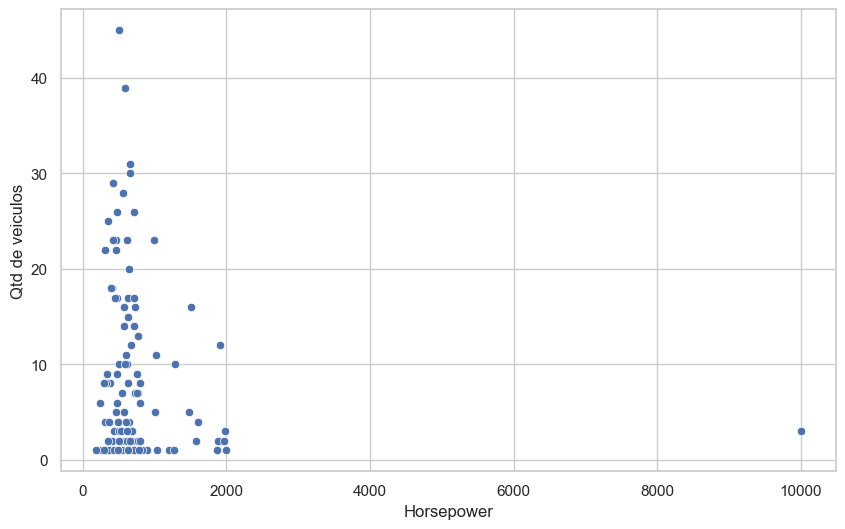

In [219]:
#Iremos realizar a plotagem de gráficos regularmente para melhor observação de outliers
plt.figure(figsize=(10,6))
plt.xlabel("Horsepower")
plt.ylabel("Qtd de veiculos")
sns.scatterplot(df["Horsepower"].value_counts())

In [220]:
outliers_acceleration = Outliers(df,"0-60 MPH Time (seconds)")
outliers_acceleration.outliers_superiores()

Index([92, 707], dtype='int64')

In [221]:
#Visto que possuimos algumas desparidades entre valores de para carros do mesmo modelo e mesmo ano

#Podemos utilizar o método de substituição por moda, visto que esses valores não deveriam ser diferentes

In [222]:
#Podemos criar uma função que evidencia valores fora da moda para carros do mesmo modelo e mesmo ano, para colunas diferentes
class ValorIncongruente:
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature
        self.indc_incongruente = []

    def encontrar_valores_incongruentes(self):
        for i in self.df[self.feature].index:
            valor = self.df.loc[i, self.feature]
            valor_car_make = self.df.loc[i, "Car Make"]
            valor_car_model = self.df.loc[i, "Car Model"]
            moda_geral = self.df.loc[(self.df["Car Make"] == valor_car_make) & 
                                      (self.df["Car Model"] == valor_car_model)][self.feature].mode()[0]

            if valor != moda_geral:
                self.indc_incongruente.append(i)
                self.df.loc[i, self.feature] = moda_geral

    def retornar_indices(self):
        return self.indc_incongruente

In [223]:
torque_incongruente = ValorIncongruente(df,"Torque (lb-ft)")
torque_incongruente.encontrar_valores_incongruentes()
indc_torque_ajustados = torque_incongruente.retornar_indices()

In [224]:
df.loc[indc_torque_ajustados]

,Car Make,Car Model,Year,Engine Size (L),Electric,Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
72,Mercedes-Benz,C63 AMG,2021,4.0,No,503,479,3.8,70100
150,Audi,RS 3,2022,2.5,No,401,354,3.6,56200
173,TVR,Griffith,2022,5.0,No,500,420,3.8,123500


<Axes: xlabel='Torque', ylabel='Qtd de veiculos'>

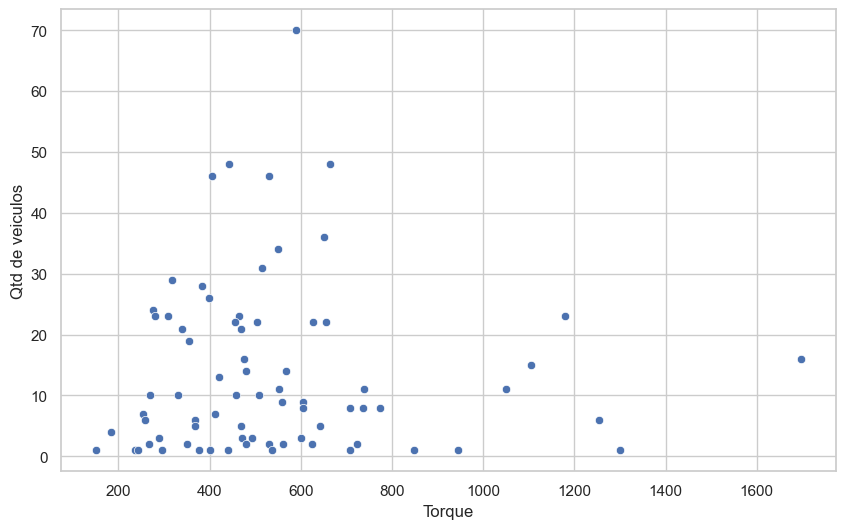

In [225]:
plt.figure(figsize=(10,6))
plt.xlabel("Torque")
plt.ylabel("Qtd de veiculos")
sns.scatterplot(df["Torque (lb-ft)"].value_counts())

In [226]:
horsepower_incongruente = ValorIncongruente(df,"Horsepower")
horsepower_incongruente.encontrar_valores_incongruentes()
indc_horsepower_ajustado = horsepower_incongruente.retornar_indices()

In [227]:
df.loc[indc_horsepower_ajustado]

,Car Make,Car Model,Year,Engine Size (L),Electric,Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
24,Pagani,Huayra,2021,6.0,No,764,738,2.80,2800000
32,BMW,M4,2022,3.0,No,473,406,3.80,72800
37,Porsche,Taycan 4S,2022,0.0,Yes,429,472,3.80,104000
39,Ferrari,Roma,2021,3.9,No,612,560,3.30,222000
49,BMW,M4,2022,3.0,No,473,406,3.80,71800
...,...,...,...,...,...,...,...,...,...
967,Porsche,Panamera Turbo S E-Hybrid,2021,0.0,Yes,690,642,3.00,190000
991,Lamborghini,Aventador,2021,6.5,No,770,531,2.90,393695
1001,Bugatti,Chiron,2021,8.0,No,1500,1180,2.40,3000000
1003,Lotus,Evija,2021,0.0,Yes,1973,1254,2.00,2000000


<Axes: xlabel='Horsepower', ylabel='Qtd de veiculos'>

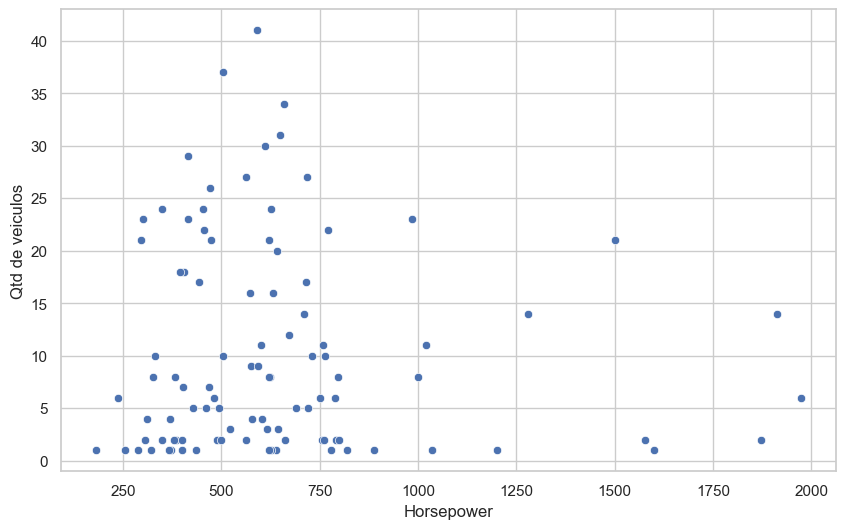

In [228]:
plt.figure(figsize=(10,6))
plt.xlabel("Horsepower")
plt.ylabel("Qtd de veiculos")
sns.scatterplot(df["Horsepower"].value_counts())

<Axes: xlabel='0-60 MPH Time (seconds)', ylabel='Qtd de veiculos'>

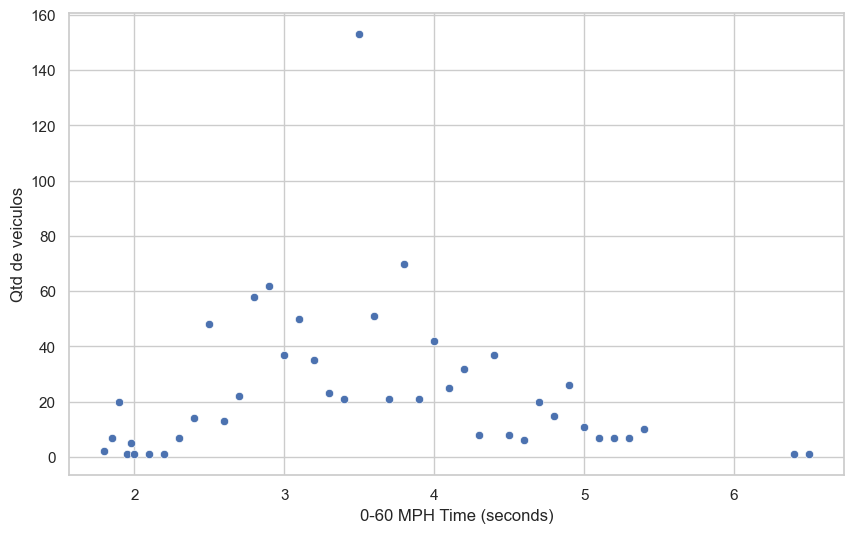

In [229]:
plt.figure(figsize=(10,6))
plt.xlabel("0-60 MPH Time (seconds)")
plt.ylabel("Qtd de veiculos")
sns.scatterplot(df["0-60 MPH Time (seconds)"].value_counts())

In [230]:
acceleration_incongruente = ValorIncongruente(df,"0-60 MPH Time (seconds)")
acceleration_incongruente.encontrar_valores_incongruentes()
indc_acceleration_ajustado = acceleration_incongruente.retornar_indices()

<Axes: xlabel='0-60 MPH Time (seconds)', ylabel='Qtd de veiculos'>

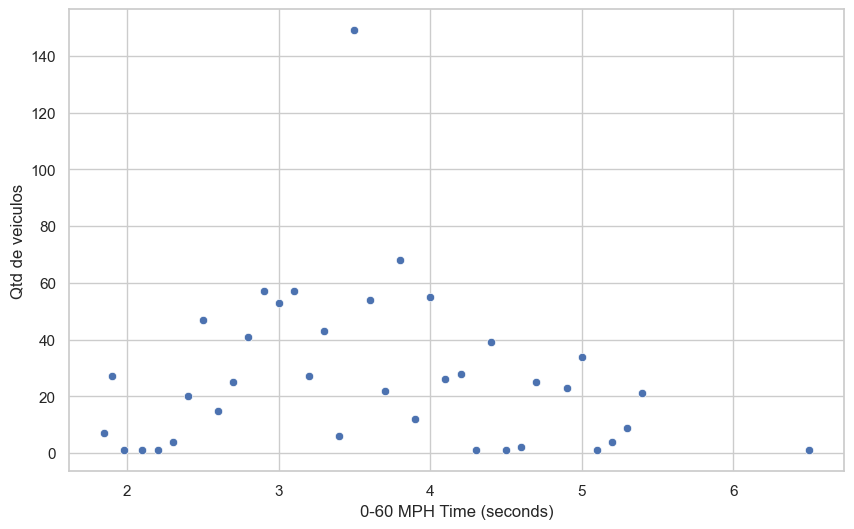

In [231]:
plt.figure(figsize=(10,6))
plt.xlabel("0-60 MPH Time (seconds)")
plt.ylabel("Qtd de veiculos")
sns.scatterplot(df["0-60 MPH Time (seconds)"].value_counts())

In [232]:
#Agora que fizemos as tratativas de valores nulos e outliers, as plotagens seguirão uma proporção mais real

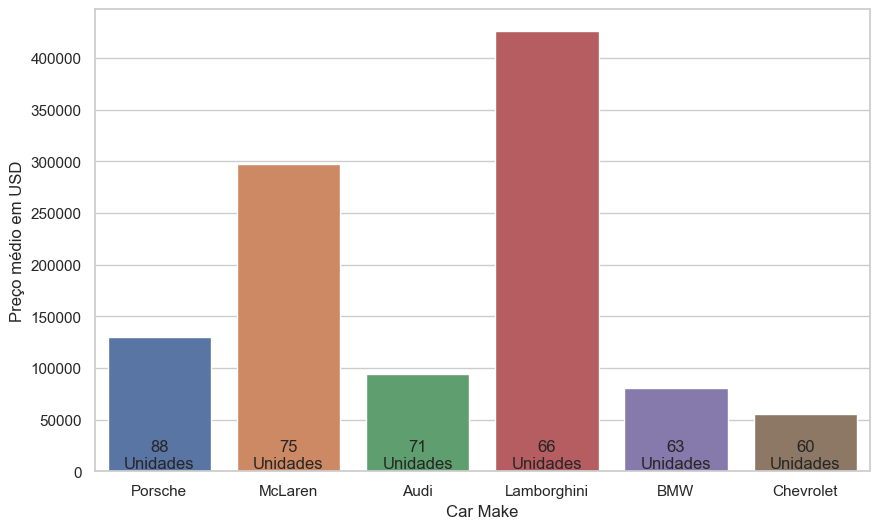

In [233]:
#Abaixo podemos avaliar as 6 marcas mais vendidas (com a quantidade de unidades vendidas) e a média de seus preços.
cinco_mais_vendidas = df['Car Make'].value_counts().head(6).index
plt.figure(figsize=(10,6))
barplot = sns.barplot(x=cinco_mais_vendidas, y= df.groupby('Car Make')['Price (in USD)'].mean().loc[cinco_mais_vendidas])
plt.ylabel("Preço médio em USD")

for index, value in enumerate(df["Car Make"].value_counts().loc[cinco_mais_vendidas]):
    barplot.text(index, value, str(value)+("\nUnidades"), ha='center',va='bottom')

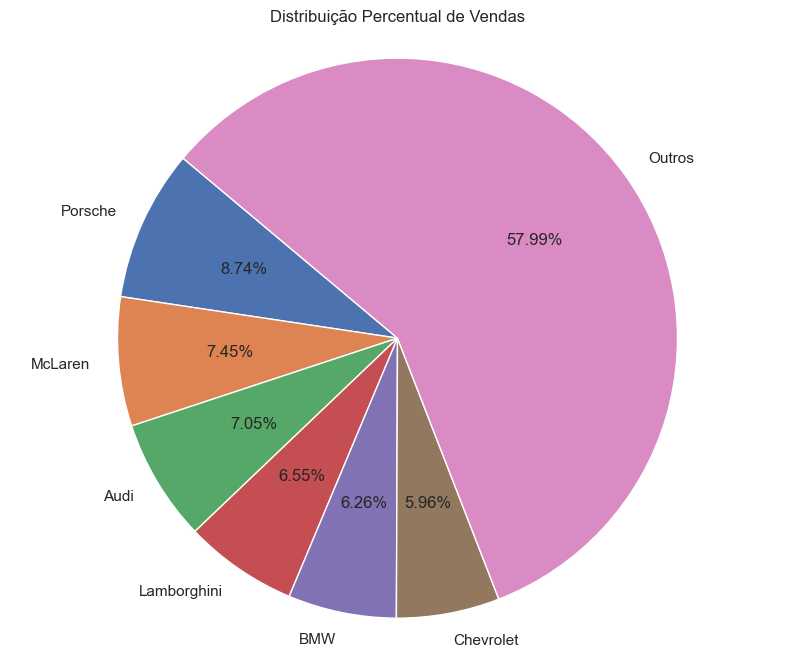

In [234]:
#Podemos também avaliar uma certa preferência por carros das 6 marcas mencionadas acima,
#visto que apenas as mesmas representam quase 50% das vendas

pctg = list(df.groupby('Car Make')['Price (in USD)'].apply(lambda x: (len(x)/df["Price (in USD)"].size) * 100).sort_values(ascending=False).values)
pctg.append(sum(pctg[6:]))
del pctg[6:-1]

labels = list(df.groupby('Car Make')['Price (in USD)'].apply(lambda x: (len(x)/df["Price (in USD)"].size) * 100).sort_values(ascending=False).index)
labels.append("Outros")
del labels[6:-1]

plt.figure(figsize=(10, 8))
plt.pie(pctg, labels=labels, autopct='%1.2f%%', startangle=140)
plt.title('Distribuição Percentual de Vendas')
plt.axis('equal') 

plt.show()

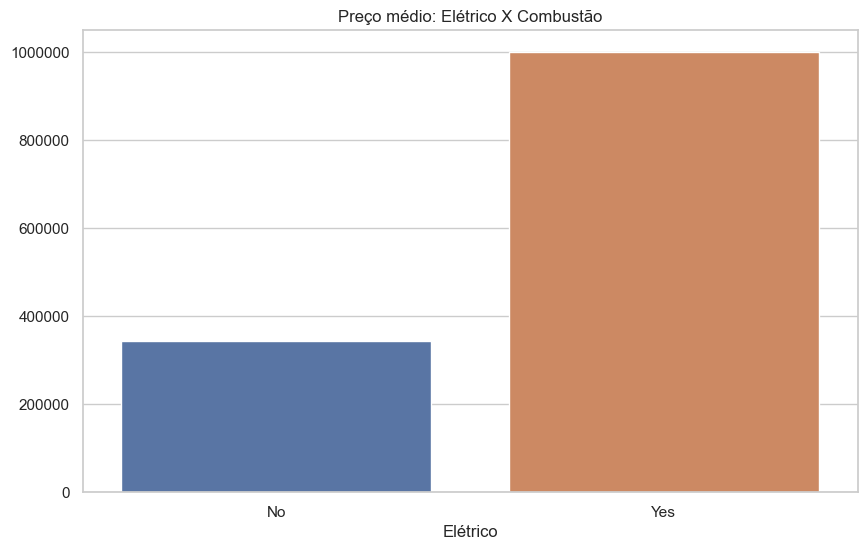

In [389]:
#Podemos observar que há uma grande disparidade entre os valores de carros elétricos e a combustão

#Onde os carros elétricos possuem o valor médio de 1 milhão de dolares
#Enquanto isso, carros a combustão possuem um valor médio de 300k dolares

plt.figure(figsize=(10,6))
sns.barplot(x = df.groupby("Electric")["Price (in USD)"].mean().index,y = df.groupby("Electric")["Price (in USD)"].mean().values)
plt.title("Preço médio: Elétrico X Combustão")
plt.xlabel("Elétrico")
plt.gca().ticklabel_format(axis='y', style='plain')

In [236]:
#Transformando variaveis categoricas em númericas para observação de suas correlações
df['Car Make Encoded'] = pd.factorize(df['Car Make'])[0]
df['Car Model Encoded'] = pd.factorize(df['Car Model'])[0]
df["Electric Encoded"] = pd.factorize(df['Electric'])[0]
df_factorized = df.drop(['Car Make','Car Model',"Electric"],axis=1)
data = df_factorized.corr()

<Axes: >

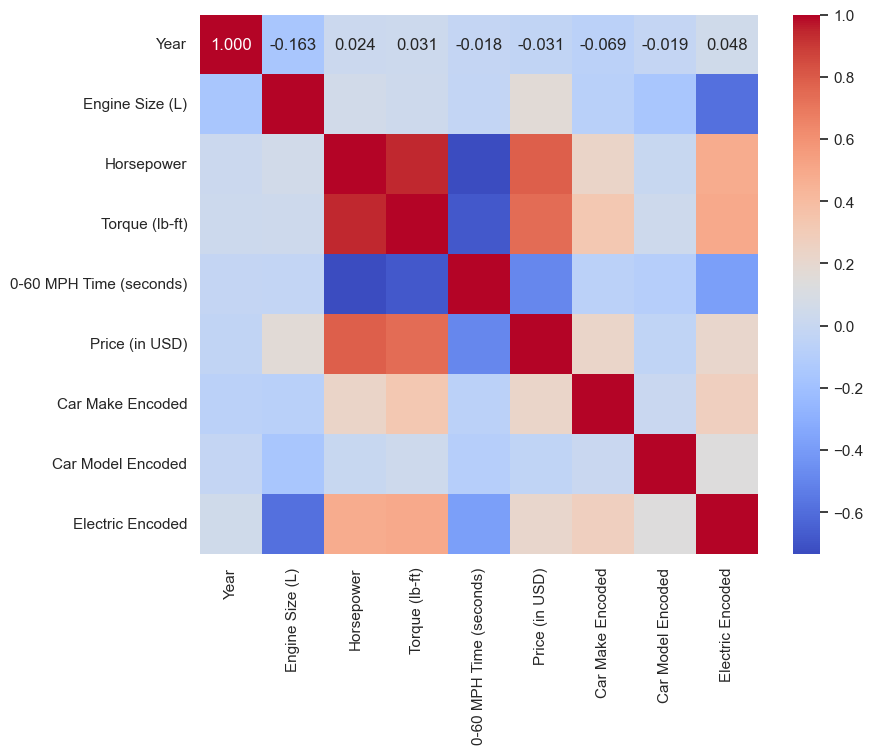

In [390]:
#Este gráfico é muito interessante para entendermos quais relações iremos evidenciar nos próximos gráficos

#Além disso, com o heatmap, temos uma visão em espectro total de nosso dataset
plt.figure(figsize=(9,7))
sns.heatmap(data,annot=True ,cmap= "coolwarm" ,fmt=".3f")

<Figure size 1000x600 with 0 Axes>

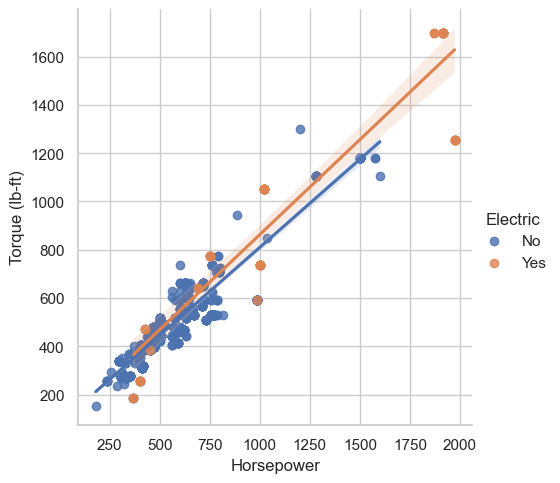

In [238]:
#Podemos observar uma forte relação entre as caracteristicas de potência do carro [Horsepower] e [Torque]
#Onde quanto maior o Horsepower, maior deve ser o Torque
plt.figure(figsize=(10,6))
sns.lmplot(data= df, x="Horsepower",y="Torque (lb-ft)",hue="Electric")

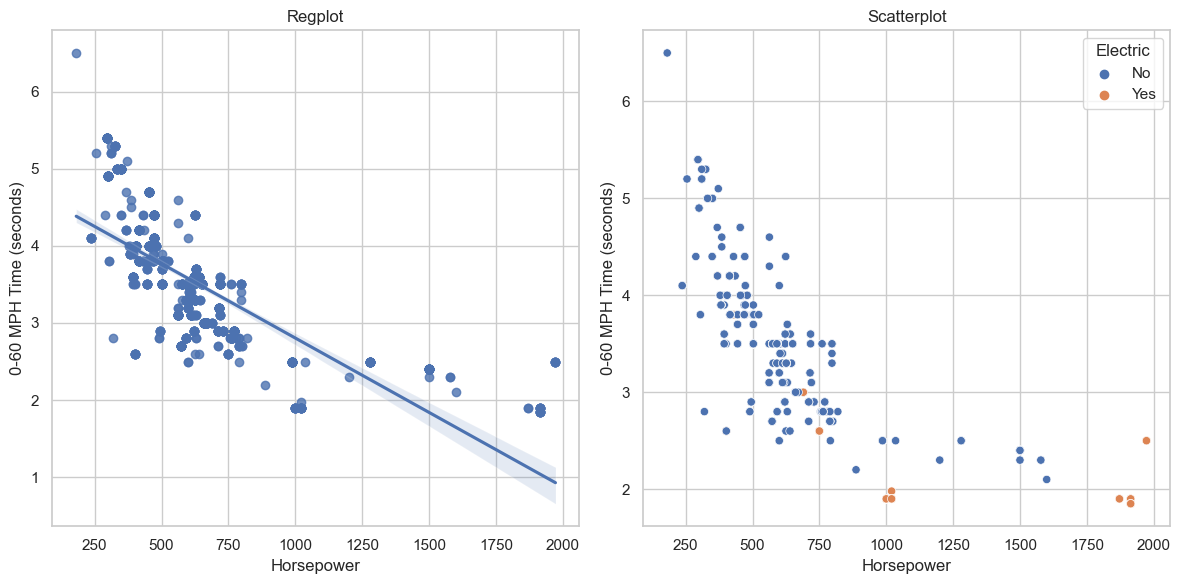

In [239]:
#Podemos observar também a relação entre a aceleração do carro [0-60 MPH Time (seconds)] e [Horsepower]
#Onde quanto menor o valor necessário para atingir 60mph, maior deve ser o Horsepower
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.regplot(data= df, x="Horsepower",y="0-60 MPH Time (seconds)",ax=axes[0])
axes[0].set_title('Regplot')

sns.scatterplot(data= df, x="Horsepower",y="0-60 MPH Time (seconds)",hue="Electric",ax=axes[1])
axes[1].set_title('Scatterplot')

plt.tight_layout()

plt.show()

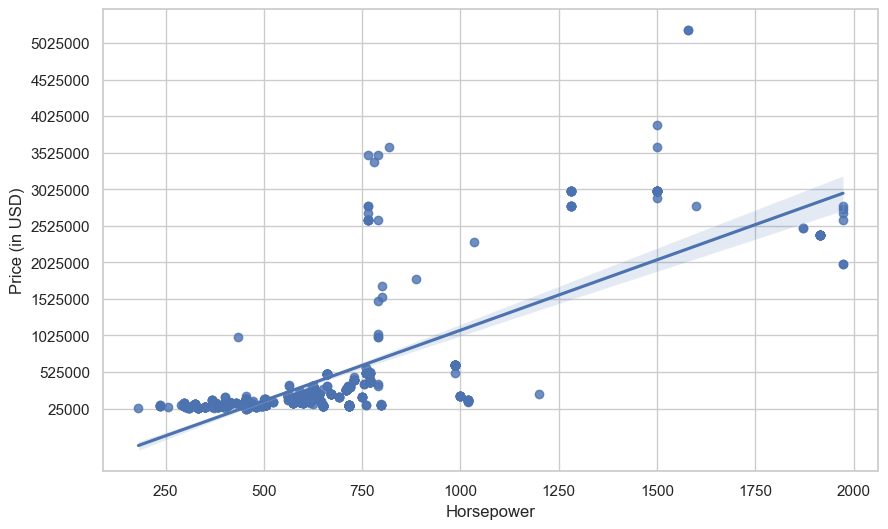

In [240]:
#Por mais que visualmente não haja um comportamento linear organizado, é possível perceber que a feature Horsepower
#é a feature que possui maior relação com o preço, dando a entender que carros com uma alta potência, tendem a ter um valor maior
plt.figure(figsize=(10,6))
sns.regplot(data=df,x=df["Horsepower"],y=df["Price (in USD)"])
ticks = [i for i in range(df["Price (in USD)"].min(),df["Price (in USD)"].max(),500000)]
plt.yticks(ticks)
plt.ticklabel_format(axis='y', style='plain')

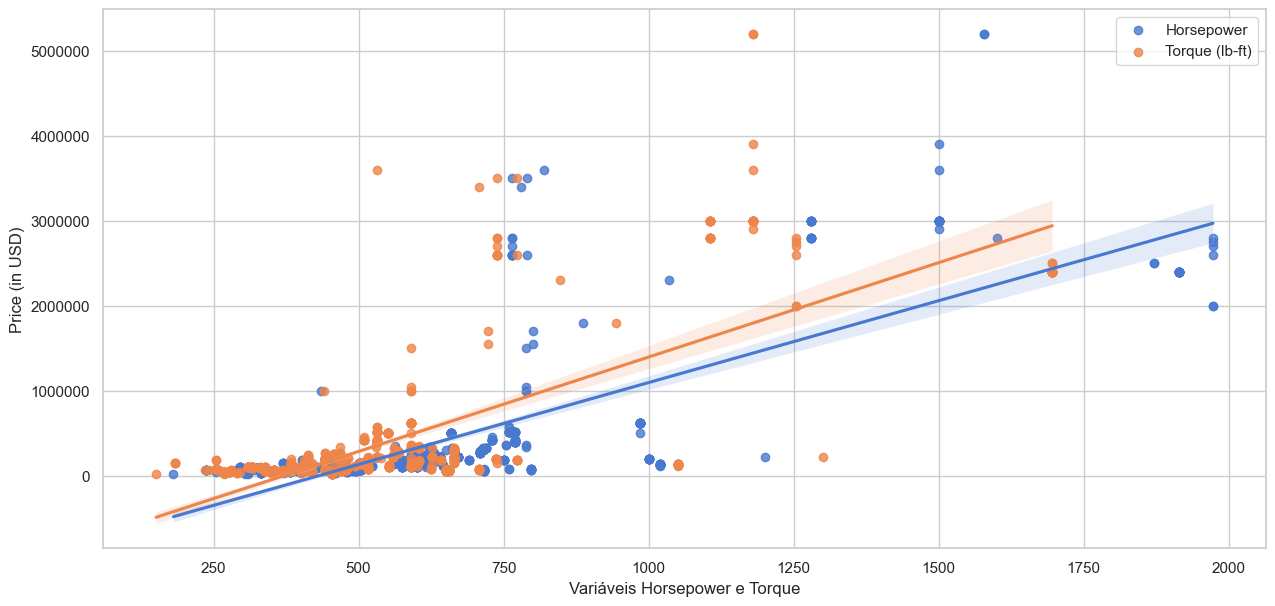

In [391]:
#Por último, podemos observar a crescente que envolve as varíaveis (Horsepower e Torque) com relação ao preço final do Automovel
plt.figure(figsize=(15,7))
palette = sns.color_palette("muted")
sns.regplot(x=df["Horsepower"], y=df["Price (in USD)"], color=palette[0], label="Horsepower")
sns.regplot(x=df["Torque (lb-ft)"],y= df["Price (in USD)"], color=palette[1], label="Torque (lb-ft)")

plt.xlabel('Variáveis Horsepower e Torque')
plt.ylabel('Price (in USD)')
plt.legend()
plt.ticklabel_format(axis='y', style='plain')
plt.grid(True)
plt.show()

In [363]:
#Irei selecionar as 4 features com maior taxa de correlação, como visto no heatmap:
features_cluster = ["Price (in USD)","Torque (lb-ft)","Horsepower","0-60 MPH Time (seconds)"]

In [364]:
#Aplicando o scalling aos nossos dados, pois possuem magnitudes diferentes, e isso impactará na interpretação dos valores
#Optei por utilizar o Min Max Scaler pois é menos sensivel a outliers
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features_cluster])

/usr/local/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Inercias')

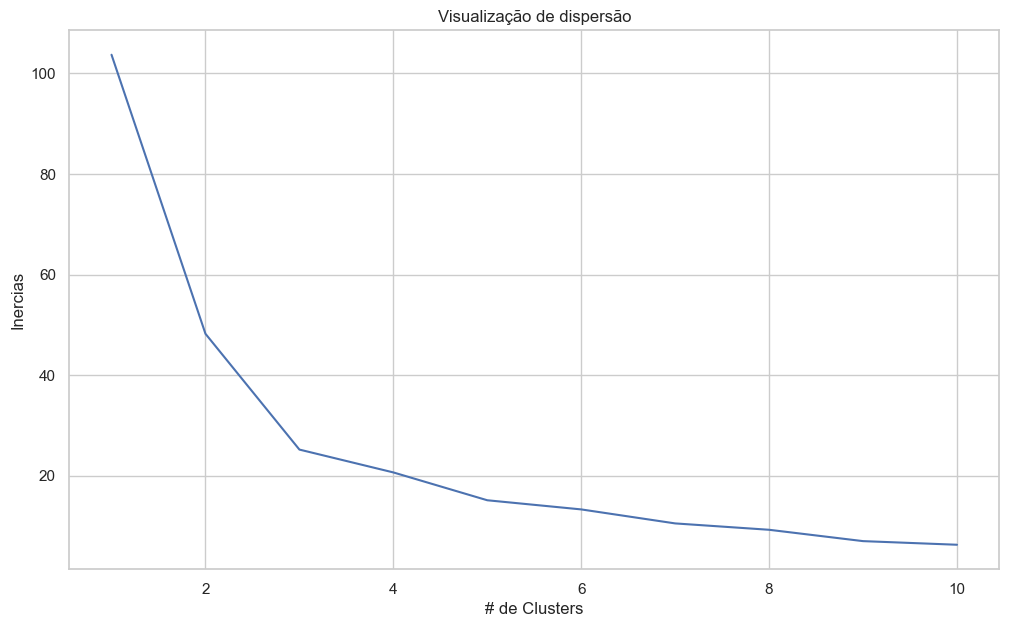

In [365]:
#Montando a lógica para plotagem do gráfico de dispersão dos valores de inercia do algoritimo K-means

inertias_X = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init= "auto", random_state=0)
    kmeans.fit(X_scaled)
    inertias_X.append(kmeans.inertia_)

#Vamos utilizar o método do elbow para definir o numero ideal de clusters
plt.figure(figsize=(12,7))
sns.lineplot(x=range(1,11),y=inertias_X)
plt.title("Visualização de dispersão")
plt.xlabel("# de Clusters")
plt.ylabel("Inercias")

In [374]:
#Utilizei o método de experimentação para definição de clusters, visto que os demais métodos não tiveram um resultado em comum

#Por mais que seguindo a linha do método "Elbow" o número ideal de clusters seria 3,
#visualmente, o sistema é melhor representado por 2 clusters

kmeans = KMeans(n_clusters=2, n_init="auto",random_state=0)
kmeans.fit(X)

In [ ]:
#Definindo uma feature para melhor visualização da relação indices/Clusters
cluster_labels = kmeans.labels_
df['Cluster'] = cluster_labels

In [ ]:
#Realizando o calculo do PCA para redimensionarmos as informações presentes no nosso dataset após o scalling

#Assim, poderemos plotar as informações de todas as features utilizadas no modelo
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

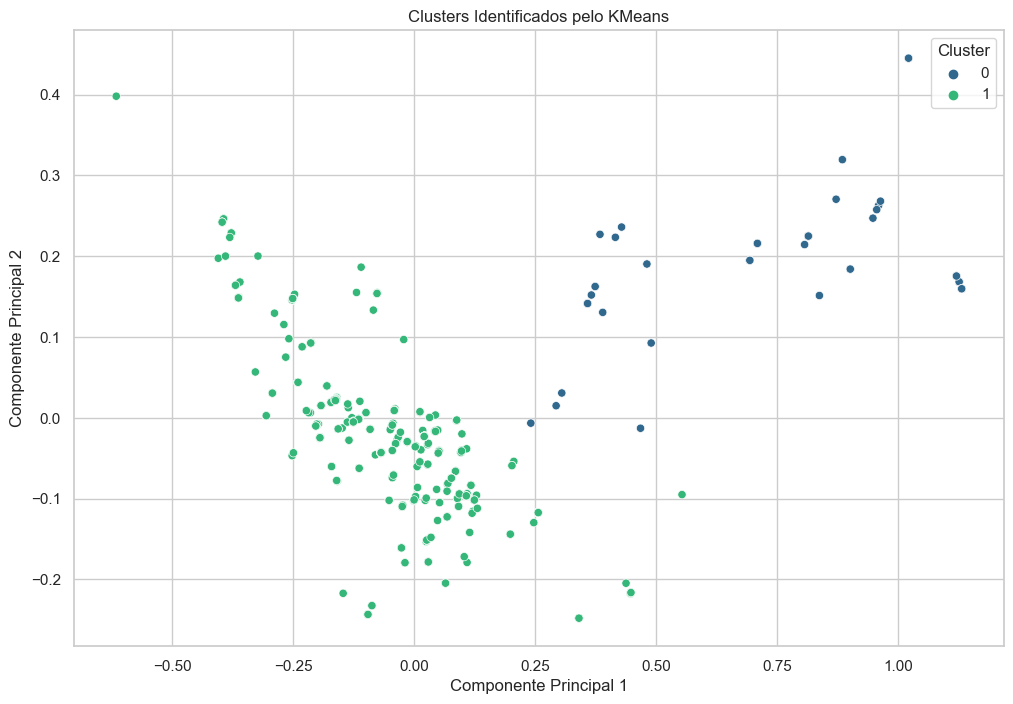

In [375]:
#Está na hora de plotar o gráfico e visualizar a distribuição das clusters
plt.figure(figsize=(12, 8))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters Identificados pelo KMeans')
plt.legend(title='Cluster')
plt.show()

/usr/local/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is 

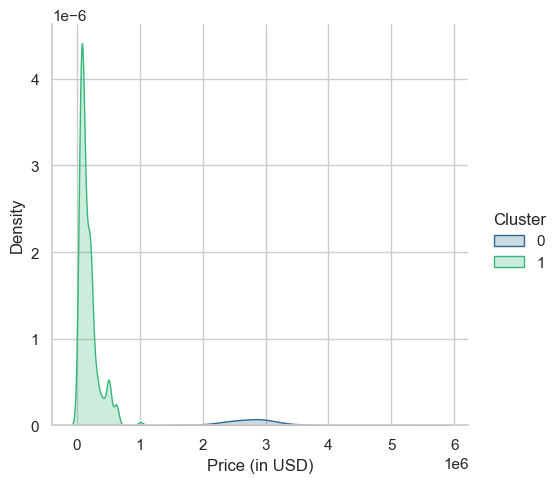

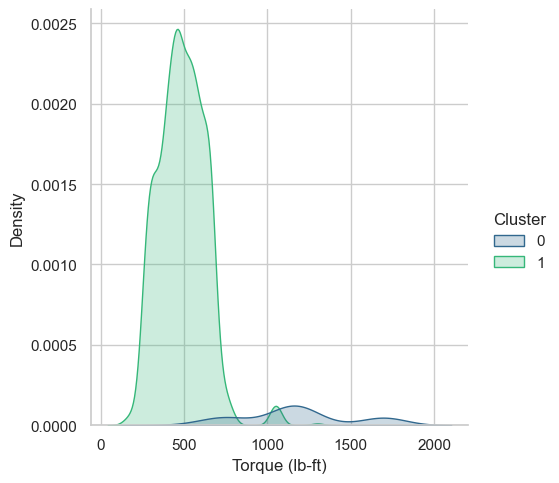

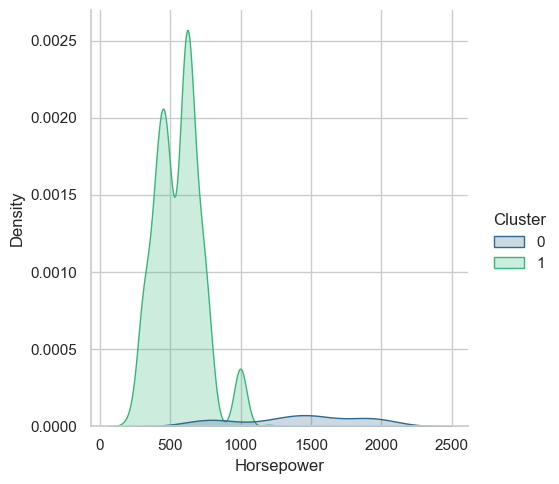

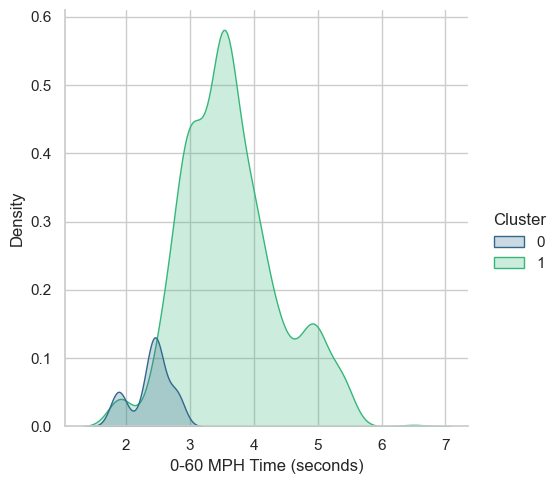

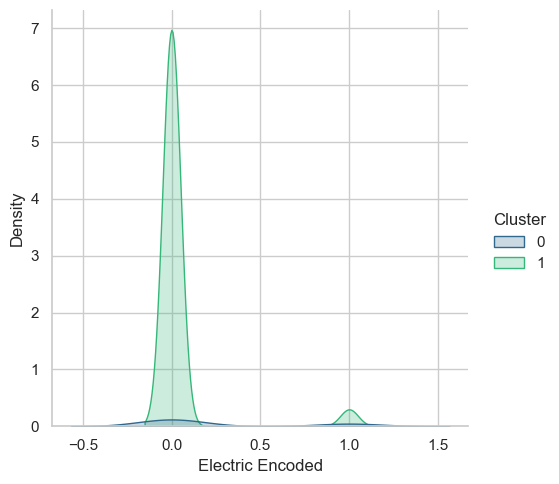

In [337]:
#Pela posição em que estão os clusters em nosso gráfico distplot KDE, podemos observar que:
#A cluster 1 é um grupo onde a probabilidade é mais evidente e maior em posições de valores menores, por exemplo:
#Menor Torque em relação a cluster 0
#Menor Horsepower em relação a cluster 0
#Menor Price in USD em relação a cluster 0

#Com isso podemos dizer que as clusters estão dividios em:
#Cluster 0: Carros de altissima performance e Luxo
#Cluster 1 : Os demais carros esportivos, com uma pequena parcela considerada altissima performance
sns.set(style="whitegrid")

for feature in features_cluster:
    sns.displot(data=df, x=feature, hue='Cluster', kind='kde',palette= "viridis", fill=True)